<a href="https://colab.research.google.com/github/christine127/Kaggle/blob/main/house_price_darkside92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 데이터 수집: kaggle 데이터 불러오기

In [2]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hyunjilee97","key":"23213e51292dcf38510875086d00ad5d"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 7.6MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=17637fd79777a8ba93d09ce61981a396832d66771a7817a260474d01e425d29d
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [5]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 79.0MB/s]


In [6]:
!unzip house-prices-advanced-regression-techniques.zip -d input

Archive:  house-prices-advanced-regression-techniques.zip
  inflating: input/data_description.txt  
  inflating: input/sample_submission.csv  
  inflating: input/test.csv          
  inflating: input/train.csv         


In [8]:
path = '/content/input/'
train_org = pd.read_csv(path+"train.csv")
train = house_df_org.copy()
test = pd.read_csv(path+ 'test.csv')
sample_sub = pd.read_csv(path+'sample_submission.csv')

## 라이브러리 불러오기

In [10]:
import numpy as np 
import pandas as pd 

from scipy.stats import skew, boxcox_normmax, boxcox
from scipy.special import boxcox1p, inv_boxcox

import seaborn as sns 
import matplotlib.pyplot as plt 
import lightgbm as lgbm
import xgboost as xgb 

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, PowerTransformer
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors 
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 5000)

shape, info, head

In [12]:
train.shape, test.shape

((1460, 81), (1459, 80))

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [11]:
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

## SalePrice와 상관분석

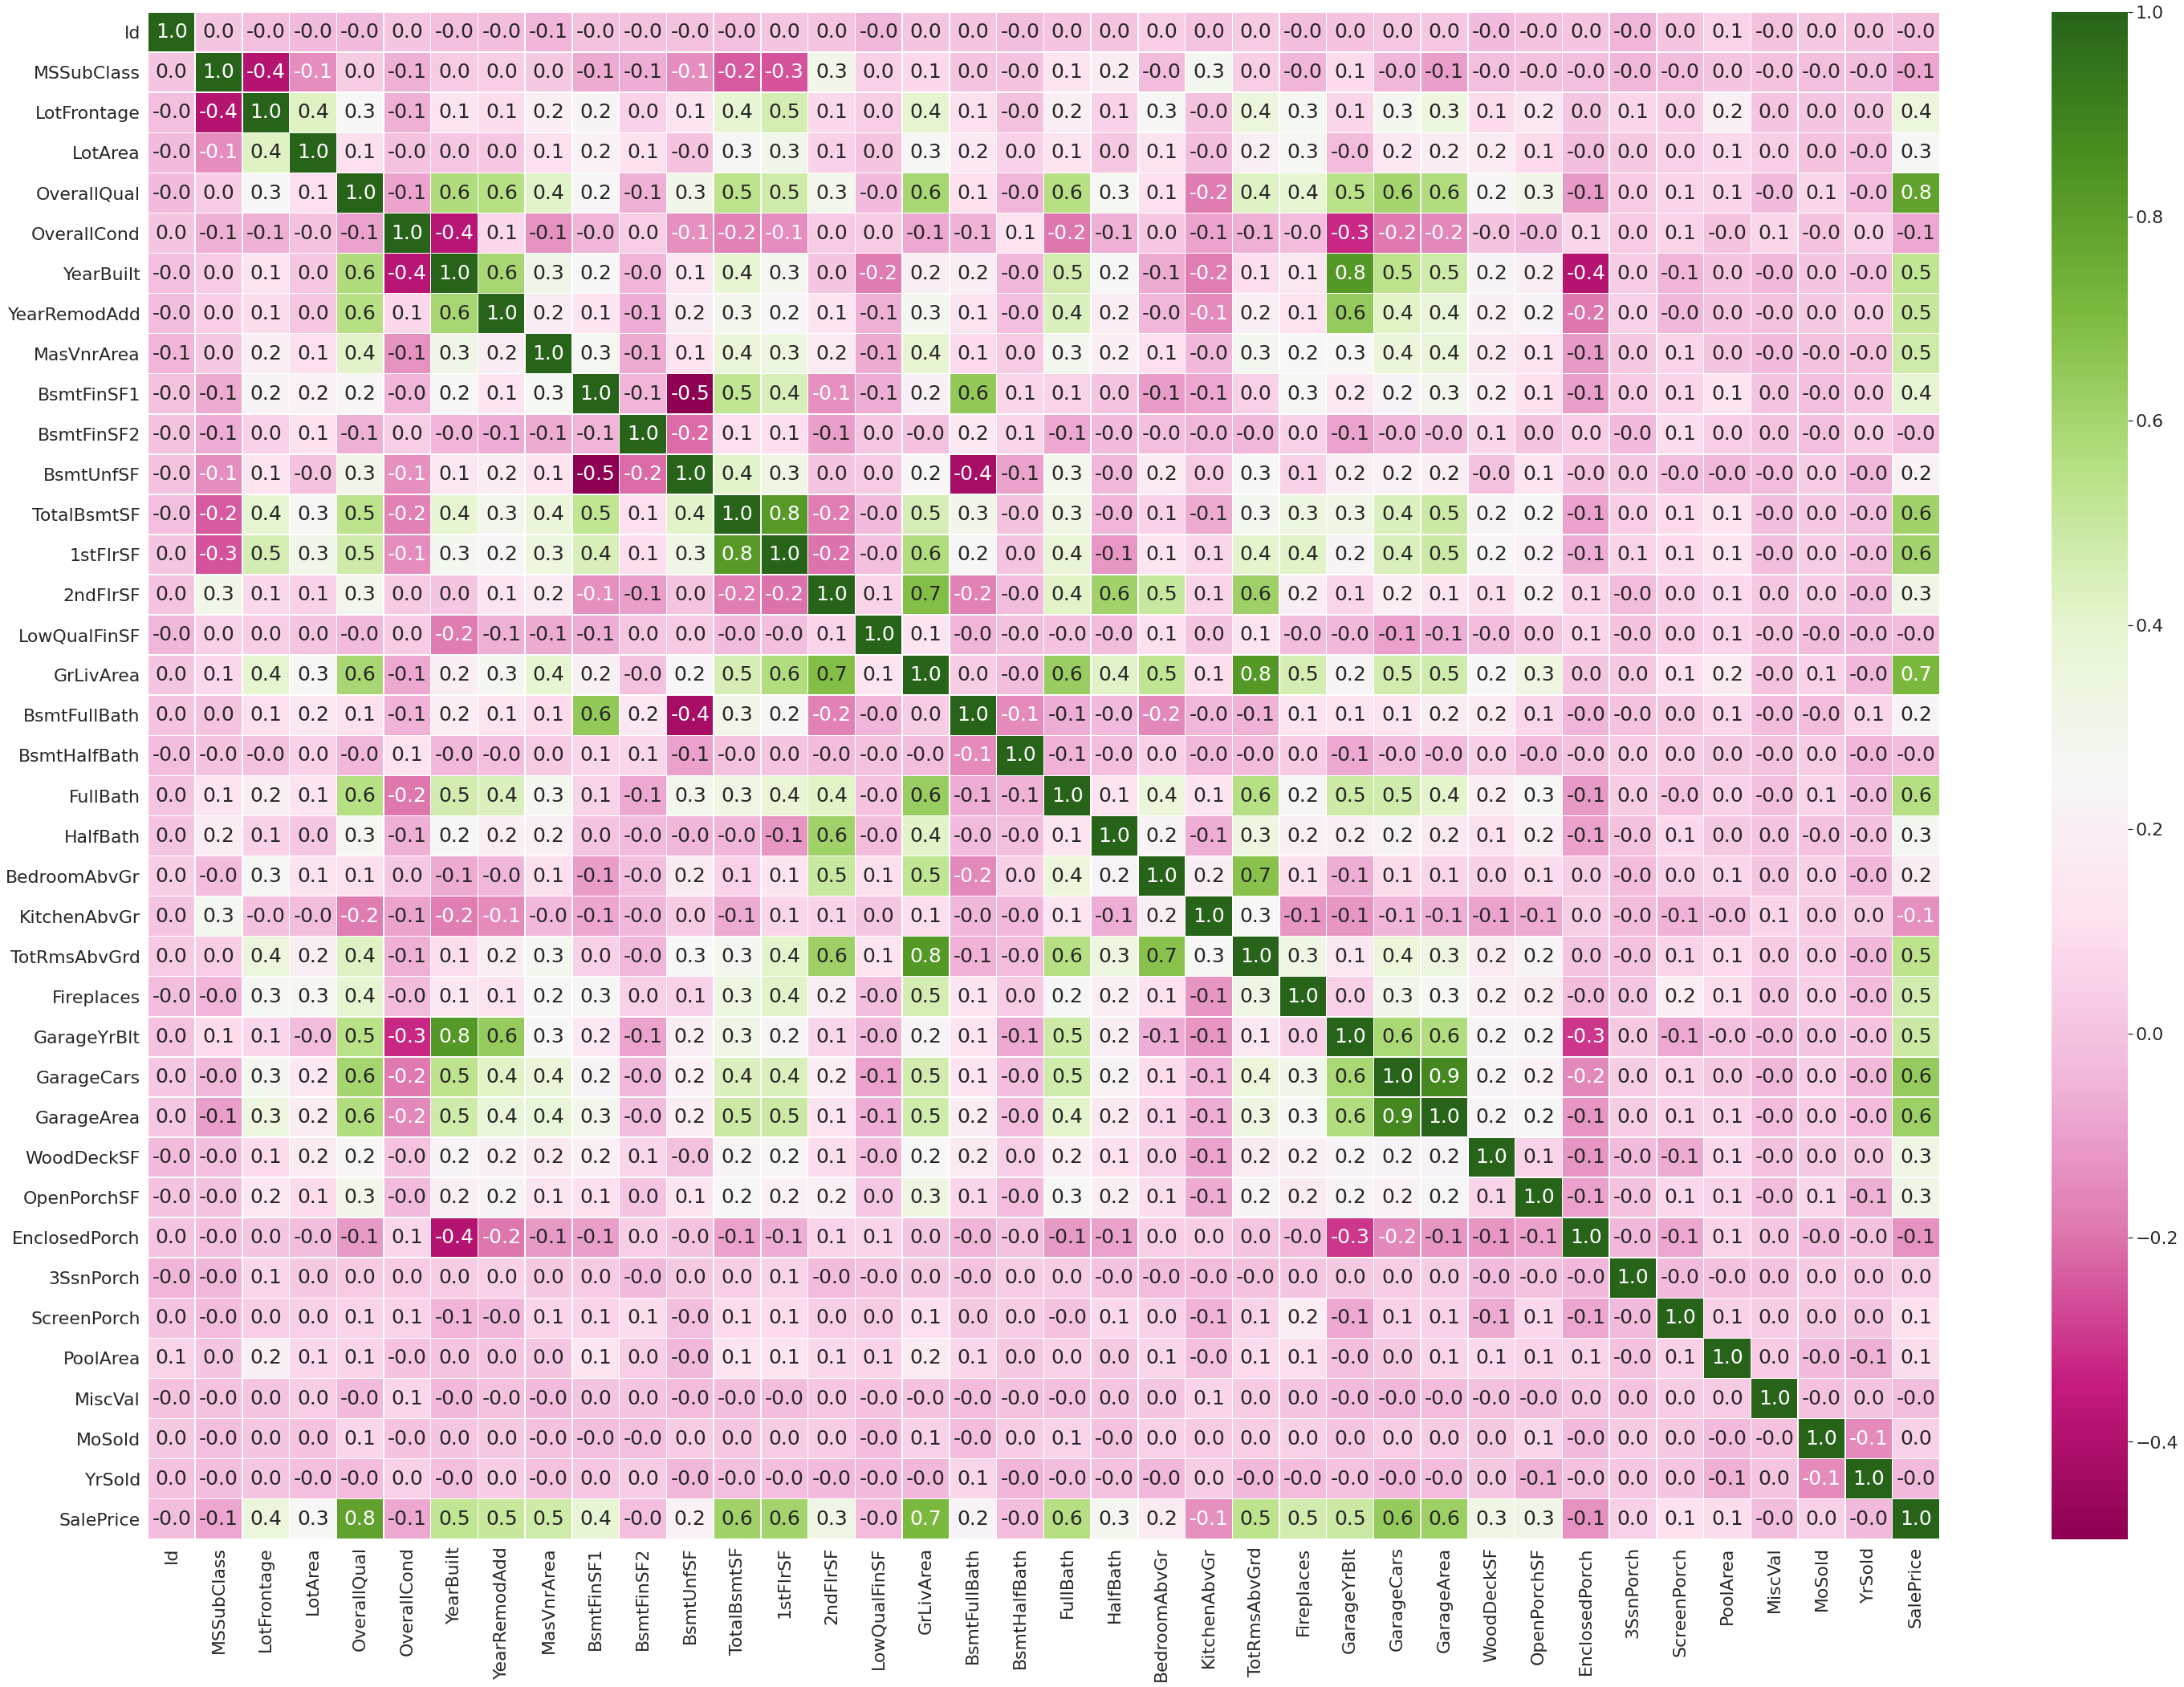

In [15]:
train_corr = train.corr()
sns.set(font_scale = 2)
plt.figure(figsize = (50,35))
ax = sns.heatmap(train_corr, annot= True, annot_kws={"size":25},cmap = 'PiYG',fmt = '.1f', linewidths= .5)

In [ ]:
corr_dict = train_corr['SalePrice'].sort_values(ascending = False).to_dict()
important_columns = []
for key, value in corr_dict.items():
    if ((value > 0.1) & (value<0.8) | (value <= -0.1)):
        important_columns.append(key)
important_columns

In [17]:
train_corr['SalePrice'][important_columns]

OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

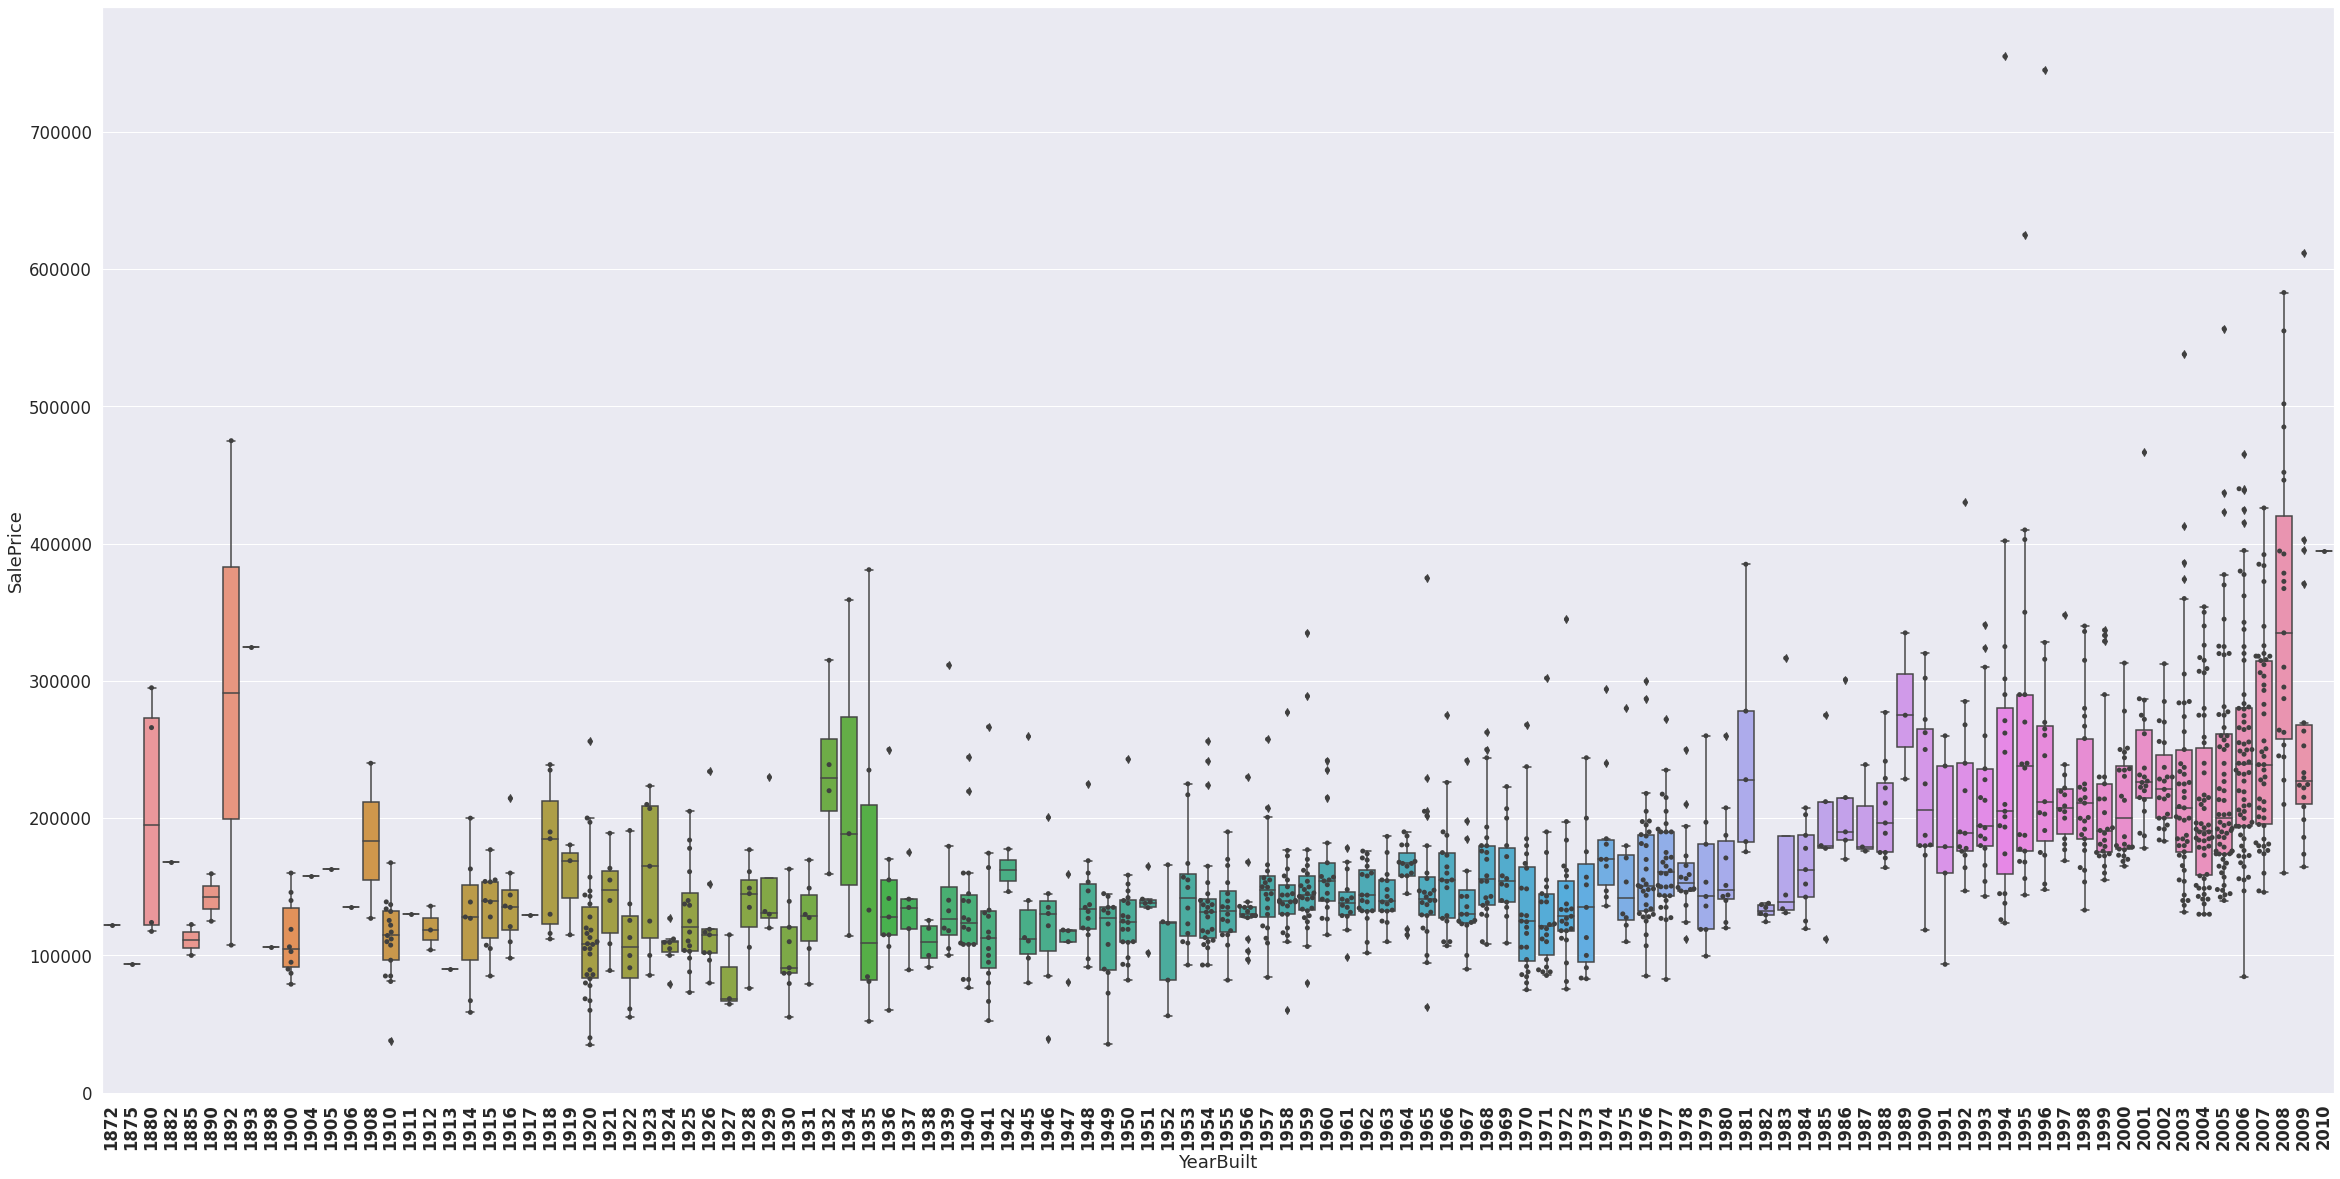

In [18]:
plt.figure(figsize = (40,20))
sns.set(font_scale = 1.5)
sns.boxplot(x= 'YearBuilt', y= 'SalePrice', data= train)
sns.swarmplot(x= 'YearBuilt', y= 'SalePrice', data= train, color= '.25')
plt.xticks(weight ='bold', rotation= 90)
plt.show()

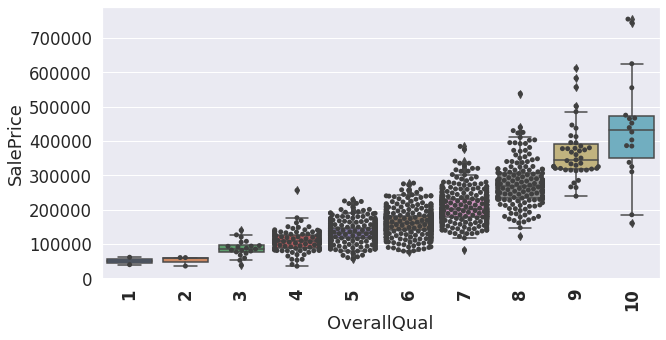

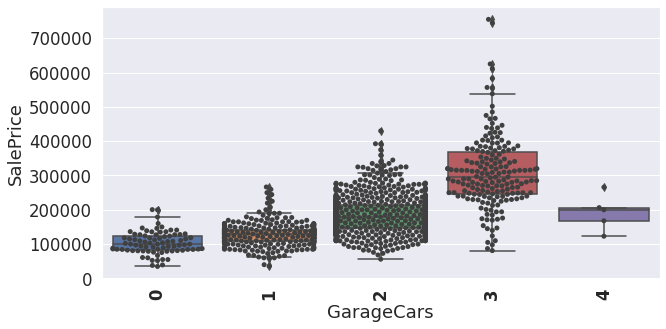

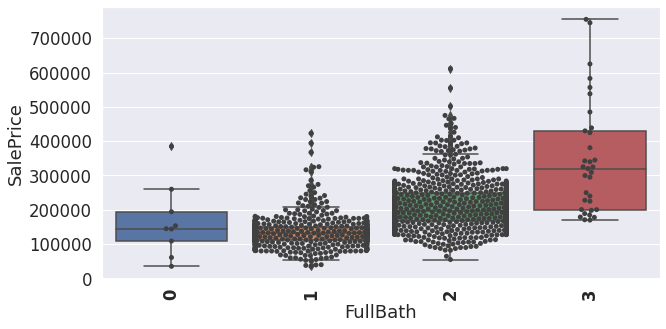

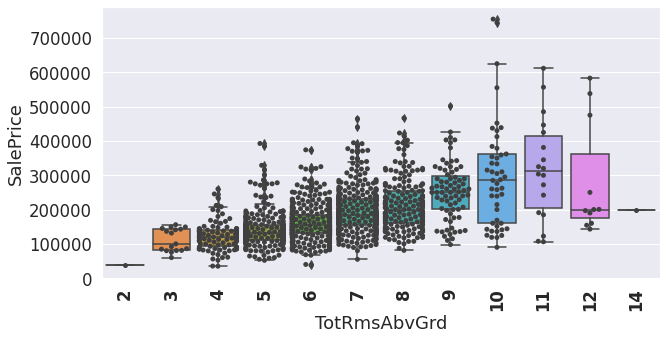

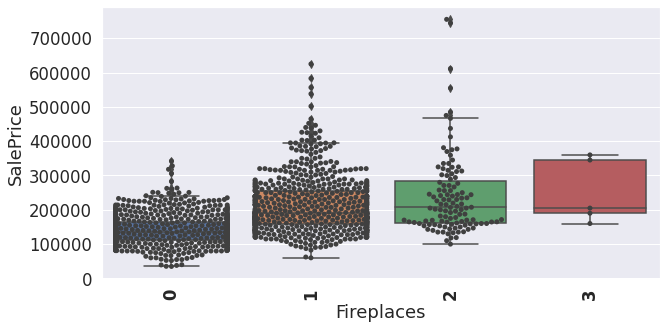

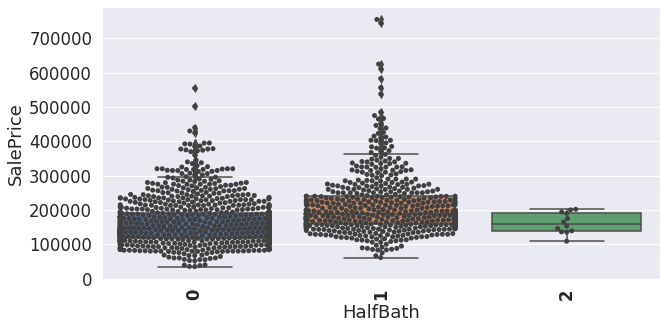

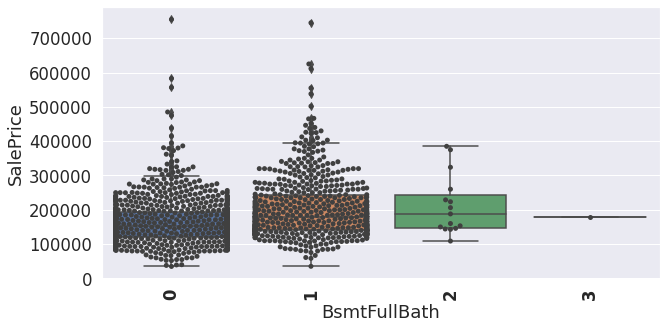

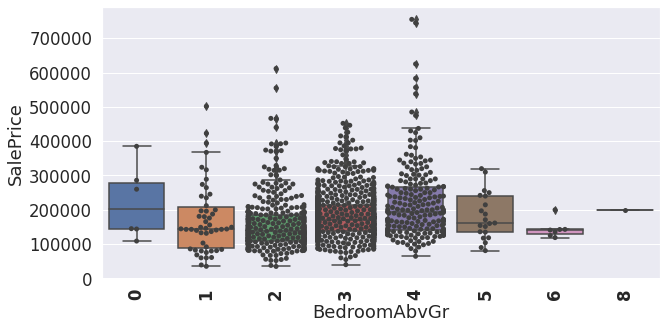

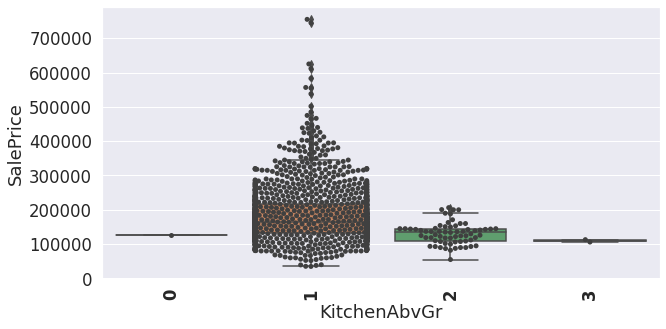

In [19]:
for col in important_columns: 
    if train[col].nunique() < 20:
        plt.figure(figsize = (10,5))
        sns.set(font_scale = 1.5)
        sns.boxplot(x= col, y= 'SalePrice', data= train)
        sns.swarmplot(x= col, y= 'SalePrice', data= train, color= '.25')
        plt.xticks(weight ='bold', rotation= 90)
        plt.show()



In [20]:
## 데이터 전처리

In [23]:
train_test = pd.concat([train,test],axis= 0, sort= False )
train_test.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ       706.0          Unf         0.0      150.0        856.0   
1          ALQ       978.0          Unf         0.0      284.0       1262.0   
2          GLQ       486.0          Unf         0.0      434.0        920.0   
3          ALQ       216.0          Unf         0.0      540.0        756.0   
4          GLQ       655.0          Unf         0.0      490.0       1145.0   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710           1.0           0.0         2         1             3   
1       1262           0.0           1.0         2         0             3   
2       1786           1.0           0.0         2         1             3   
3       1717           1.0           0.0         1         0             3   
4       2198           1.0           0.0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

In [24]:
train_test_null_info = pd.DataFrame(train_test.isnull().sum(), columns = ['Count of NaN'])
train_test_dtype_info = pd.DataFrame(train_test.dtypes, columns = ['DataTypes'])
train_test_info = pd.concat([train_test_null_info, train_test_dtype_info], axis=1)
train_test_info

Count of NaN DataTypes
Id                        0     int64
MSSubClass                0     int64
MSZoning                  4    object
LotFrontage             486   float64
LotArea                   0     int64
Street                    0    object
Alley                  2721    object
LotShape                  0    object
LandContour               0    object
Utilities                 2    object
LotConfig                 0    object
LandSlope                 0    object
Neighborhood              0    object
Condition1                0    object
Condition2                0    object
BldgType                  0    object
HouseStyle                0    object
OverallQual               0     int64
OverallCond               0     int64
YearBuilt                 0     int64
YearRemodAdd              0     int64
RoofStyle                 0    object
RoofMatl                  0    object
Exterior1st               1    object
Exterior2nd               1    object
MasVnrType               24    object
MasVnrArea               23   float64
ExterQual                 0    object
ExterCond                 0    object
Foundation                0    object
BsmtQual                 81    object
BsmtCond                 82    object
BsmtExposure             82    object
BsmtFinType1             79    object
BsmtFinSF1                1   float64
BsmtFinType2             80    object
BsmtFinSF2                1   float64
BsmtUnfSF                 1   float64
TotalBsmtSF               1   float64
Heating                   0    object
HeatingQC                 0    object
CentralAir                0    object
Electrical                1    object
1stFlrSF                  0     int64
2ndFlrSF                  0     int64
LowQualFinSF              0     int64
GrLivArea                 0     int64
BsmtFullBath              2   float64
BsmtHalfBath              2   float64
FullBath                  0     int64
HalfBath                  0     int64
BedroomAbvGr              0     int64
KitchenAbvGr              0     int64
KitchenQual               1    object
TotRmsAbvGrd              0     int64
Functional                2    object
Fireplaces                0     int64
FireplaceQu            1420    object
GarageType              157    object
GarageYrBlt             159   float64
GarageFinish            159    object
GarageCars                1   float64
GarageArea                1   float64
GarageQual              159    object
GarageCond              159    object
PavedDrive                0    object
WoodDeckSF                0     int64
OpenPorchSF               0     int64
EnclosedPorch             0     int64
3SsnPorch                 0     int64
ScreenPorch               0     int64
PoolArea                  0     int64
PoolQC                 2909    object
Fence                  2348    object
MiscFeature            2814    object
MiscVal                   0     int64
MoSold                    0     int64
YrSold                    0     int64
SaleType                  1    object
SaleCondition             0    object
SalePrice              1459   float64

## 결측치 처리 , Feature Engineering

In [36]:
## Fireplaces :Number of fireplaces
train_test.loc[train_test['Fireplaces']==0, 'FireplaceQu'] = 'Nothing'

## LotFrontage: Linear feet of street connected to property
train_test['LotFrontage']= train_test['LotFrontage'].fillna(train_test.groupby('1stFlrSF')['LotFrontage'].transform('mean'))
train_test['LotFrontage'].interpolate(method='linear', inplace= True)
train_test['LotFrontage'] = train_test['LotFrontage'].astype(int)

##MasVnrArea : Masonry veneer area in square feet
train_test['MasVnrArea'] = train_test['MasVnrArea'].fillna(train_test.groupby('MasVnrType')['MasVnrArea'].transform('mean'))
train_test['MasVnrArea'].interpolate(method='linear', inplace= True)
train_test['MasVnrArea']= train_test['MasVnrArea'].astype(int)

#Fence
train_test['Fence'] = train_test['Fence'].fillna('None')

#FirePlaceQu :Fireplace quality
train_test['FireplaceQu']= train_test['FireplaceQu'].fillna("None")

#Alley: Type of alley access to property
train_test['Alley']= train_test['Alley'].fillna('None')

#PoolQC
train_test['PoolQC'] = train_test['PoolQC'].fillna("None")

#MiscFeature :Miscellaneous feature not covered in other categories
train_test['MiscFeature']= train_test['MiscFeature'].fillna("None")

#BsmtFinType1:Rating of basement finished area/BsmtFinSF1: Type 1 finished square 
#Type2: multiple types
train_test.loc[train_test['BsmtFinSF1']==0, 'BsmtFinType1'] ='Unf'
train_test.loc[train_test['BsmtFinSF2']==0, 'BsmtQual'] = 'TA'

In [38]:
#데이터 가공
train_test['YrBltRmd']= train_test['YearBuilt'] + train_test['YearRemodAdd']
train_test['Total_Square_Feet'] = (train_test['BsmtFinSF1']+ train_test['2ndFlrSF']+train_test['TotalBsmtSF'])
train_test['Total_Bath'] = train_test['FullBath']+ 0.5* train_test['HalfBath'] + train_test['BsmtFullBath'] + 0.5* train_test['BsmtHalfBath']
train_test['Total_Porch_Area']= train_test['OpenPorchSF'] + train_test['3SsnPorch']+ train_test['EnclosedPorch']+train_test['ScreenPorch']+ train_test['WoodDeckSF']
train_test['exists_pool'] = train_test['PoolArea'].apply(lambda x: 1 if x>0 else 0)
train_test['exists_garage']= train_test['GarageArea'].apply(lambda x:1 if x>0 else 0 )
train_test['exists_fireplace']= train_test['Fireplaces'].apply(lambda x:1 if x>0 else 0)
train_test['exists_bsmt'] = train_test['TotalBsmtSF'].apply(lambda x: 1 if x>0 else 0)
train_test['old_house']= train_test['YearBuilt'].apply(lambda x:1 if x<1990 else 0)

In [39]:
for i in train_test.columns:
  if 'SalePrice' not in i:
    if 'object' in str(train_test[str(i)].dtype):
      train_test[str(i)] = train_test[str(i)].fillna(method= 'ffill')

In [46]:
columns = ['FireplaceQu','BsmtQual','BsmtCond','ExterQual','ExterCond','GarageQual','GarageCond',
           'HeatingQC','PoolQC','KitchenQual','BsmtFinType1','YrSold','MoSold','BsmtFinType2',
           'Functional','Fence','BsmtExposure','GarageFinish','LandSlope','LotShape',
           'PavedDrive','Street','Alley','CentralAir','MSSubClass','OverallCond']

for col in columns:
  le_encoder = LabelEncoder()
  le_encoder.fit(list(train_test[col].values))
  train_test[col]= le_encoder.transform(list(train_test[col].values))

In [48]:
numeric_features = train_test.dtypes[train_test.dtypes != 'object'].index
skewed_features = train_test[numeric_features].apply(lambda x : skew(x)).sort_values(ascending =False)
print(skewed_features)

MiscVal              21.947195
PoolArea             16.898328
exists_pool          14.884318
LotArea              12.822431
LowQualFinSF         12.088761
3SsnPorch            11.376065
LandSlope             4.975157
KitchenAbvGr          4.302254
EnclosedPorch         4.003891
ScreenPorch           3.946694
MasVnrArea            2.600375
OpenPorchSF           2.535114
WoodDeckSF            1.842433
LotFrontage           1.483631
1stFlrSF              1.469604
Total_Porch_Area      1.376649
GrLivArea             1.269358
2ndFlrSF              0.861675
TotRmsAbvGrd          0.758367
MSSubClass            0.738722
Fireplaces            0.733495
HalfBath              0.694566
OverallCond           0.570312
HeatingQC             0.486656
FireplaceQu           0.333787
BedroomAbvGr          0.326324
OverallQual           0.197110
MoSold                0.195884
FullBath              0.167606
YrSold                0.132399
Id                    0.000000
exists_fireplace     -0.054148
BsmtFinT

In [54]:
high_skewness = skewed_features[abs(skewed_features)>0.9]
skewed_features = high_skewness.index

In [55]:
print(high_skewness)
print('\nVariables with high skewness\n\n', skewed_features)

MiscVal             21.947195
PoolArea            16.898328
exists_pool         14.884318
LotArea             12.822431
LowQualFinSF        12.088761
3SsnPorch           11.376065
LandSlope            4.975157
KitchenAbvGr         4.302254
EnclosedPorch        4.003891
ScreenPorch          3.946694
MasVnrArea           2.600375
OpenPorchSF          2.535114
WoodDeckSF           1.842433
LotFrontage          1.483631
1stFlrSF             1.469604
Total_Porch_Area     1.376649
GrLivArea            1.269358
BsmtExposure        -1.176341
KitchenQual         -1.448023
ExterQual           -1.801409
Fence               -1.993777
ExterCond           -2.497719
PavedDrive          -2.979084
BsmtCond            -3.301446
BsmtFinType2        -3.412861
CentralAir          -3.459022
GarageQual          -3.919880
exists_garage       -3.941054
Functional          -4.055757
GarageCond          -5.147262
exists_bsmt         -5.828995
BsmtQual            -6.303596
Street             -15.500133
PoolQC    

In [56]:
train_test[skewed_features].head()

MiscVal  PoolArea  exists_pool  LotArea  LowQualFinSF  3SsnPorch  \
0        0         0            0     8450             0          0   
1        0         0            0     9600             0          0   
2        0         0            0    11250             0          0   
3        0         0            0     9550             0          0   
4        0         0            0    14260             0          0   

   LandSlope  KitchenAbvGr  EnclosedPorch  ScreenPorch  MasVnrArea  \
0          0             1              0            0         196   
1          0             1              0            0           0   
2          0             1              0            0         162   
3          0             1            272            0           0   
4          0             1              0            0         350   

   OpenPorchSF  WoodDeckSF  LotFrontage  1stFlrSF  Total_Porch_Area  \
0           61           0           65       856                61   
1            0         298           80      1262               298   
2           42           0           68       920                42   
3           35           0           60       961               307   
4           84         192           84      1145               276   

   GrLivArea  BsmtExposure  KitchenQual  ExterQual  Fence  ExterCond  \
0       1710             3            2          2      4          4   
1       1262             1            3          3      4          4   
2       1786             2            2          2      4          4   
3       1717             3            2          3      4          4   
4       2198             0            2          2      4          4   

   PavedDrive  BsmtCond  BsmtFinType2  CentralAir  GarageQual  exists_garage  \
0           2         3             5           1           4              1   
1           2         3             5           1           4              1   
2           2         3             5           1           4              1   
3           2         1             5           1           4              1   
4           2         3             5           1           4              1   

   Functional  GarageCond  exists_bsmt  BsmtQual  Street  PoolQC  
0           6           4            1         3       1       3  
1           6           4            1         3       1       3  
2           6           4            1         3       1       3  
3           6           4            1         3       1       3  
4           6           4            1         3       1       3

In [59]:
for feature in skewed_features:
  train_test[feature] = boxcox1p(train_test[feature], boxcox_normmax(train_test[feature]+1))

In [61]:
train_test[skewed_features].head()

MiscVal  PoolArea  exists_pool    LotArea  LowQualFinSF  3SsnPorch  \
0      0.0       0.0          0.0  13.424520           0.0        0.0   
1      0.0       0.0          0.0  13.694527           0.0        0.0   
2      0.0       0.0          0.0  14.034133           0.0        0.0   
3      0.0       0.0          0.0  13.683421           0.0        0.0   
4      0.0       0.0          0.0  14.550142           0.0        0.0   

   LandSlope  KitchenAbvGr  EnclosedPorch  ScreenPorch  MasVnrArea  \
0        0.0       0.75096       0.000000          0.0   19.509966   
1        0.0       0.75096       0.000000          0.0    0.000000   
2        0.0       0.75096       0.000000          0.0   17.835996   
3        0.0       0.75096      16.012025          0.0    0.000000   
4        0.0       0.75096       0.000000          0.0   25.518156   

   OpenPorchSF  WoodDeckSF  LotFrontage  1stFlrSF  Total_Porch_Area  \
0    12.009558    0.000000    13.668864  5.318379         18.721469   
1     0.000000   56.339208    15.311587  5.550627         51.575368   
2     9.849185    0.000000    14.011693  5.362015         14.644413   
3     8.921746    0.000000    13.079140  5.388291         52.547847   
4    14.180238   42.351292    15.722536  5.493032         49.148914   

   GrLivArea  BsmtExposure  KitchenQual  ExterQual     Fence  ExterCond  \
0   7.234115      6.112249     5.077704   5.498765  6.897404   5.100237   
1   6.947212      1.372290    10.302990  11.456357  6.897404   5.100237   
2   7.275132      3.429155     5.077704   5.498765  6.897404   5.100237   
3   7.237969      6.112249     5.077704  11.456357  6.897404   5.100237   
4   7.470741      0.000000     5.077704   5.498765  6.897404   5.100237   

   PavedDrive  BsmtCond  BsmtFinType2  CentralAir  GarageQual  exists_garage  \
0   10.465804  5.218987   1444.255548   72.932968   23.440981       1.096819   
1   10.465804  5.218987   1444.255548   72.932968   23.440981       1.096819   
2   10.465804  5.218987   1444.255548   72.932968   23.440981       1.096819   
3   10.465804  1.280547   1444.255548   72.932968   23.440981       1.096819   
4   10.465804  5.218987   1444.255548   72.932968   23.440981       1.096819   

   Functional  GarageCond  exists_bsmt   BsmtQual    Street       PoolQC  
0   30.831053  2952.40927    41.797413  54.556642  1.965139  3975.432981  
1   30.831053  2952.40927    41.797413  54.556642  1.965139  3975.432981  
2   30.831053  2952.40927    41.797413  54.556642  1.965139  3975.432981  
3   30.831053  2952.40927    41.797413  54.556642  1.965139  3975.432981  
4   30.831053  2952.40927    41.797413  54.556642  1.965139  3975.432981

In [75]:
train_test = pd.get_dummies(train_test, dtype='int8')

## train-test 분할

In [79]:
train = train_test[:len(train)]
test =train_test[len(train):]

In [83]:
train.interpolate(method='linear',inplace= True)
test.interpolate(method='linear', inplace= True)

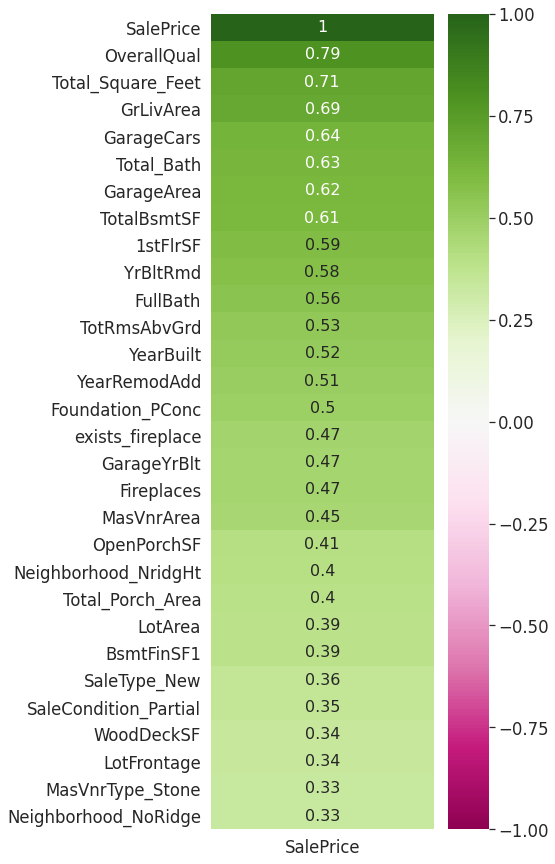

In [85]:
corr_new_train= train.corr()
plt.figure(figsize = (5,15))
sns.heatmap(corr_new_train[['SalePrice']].sort_values(by=['SalePrice'], ascending = False).head(30),
            annot_kws = {"size":16}, vmin=-1, cmap='PiYG', annot= True)
sns.set(font_scale = 2)

In [86]:
corr_dict2 = corr_new_train['SalePrice'].sort_values(ascending =False).to_dict()

In [87]:
best_columns= []
for key, value in corr_dict2.items():
  if ((value>= 0.3175) & (value<0.9))| (value <= -0.315):
    best_columns.append(key)
best_columns

['OverallQual',
 'Total_Square_Feet',
 'GrLivArea',
 'GarageCars',
 'Total_Bath',
 'GarageArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'YrBltRmd',
 'FullBath',
 'TotRmsAbvGrd',
 'YearBuilt',
 'YearRemodAdd',
 'Foundation_PConc',
 'exists_fireplace',
 'GarageYrBlt',
 'Fireplaces',
 'MasVnrArea',
 'OpenPorchSF',
 'Neighborhood_NridgHt',
 'Total_Porch_Area',
 'LotArea',
 'BsmtFinSF1',
 'SaleType_New',
 'SaleCondition_Partial',
 'WoodDeckSF',
 'LotFrontage',
 'MasVnrType_Stone',
 'Neighborhood_NoRidge',
 '2ndFlrSF',
 'Foundation_CBlock',
 'MasVnrType_None',
 'GarageType_Detchd',
 'HeatingQC',
 'GarageFinish',
 'old_house',
 'KitchenQual',
 'ExterQual']

In [88]:
print(len(best_columns))

38


(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38]), <a list of 38 Text major ticklabel objects>)

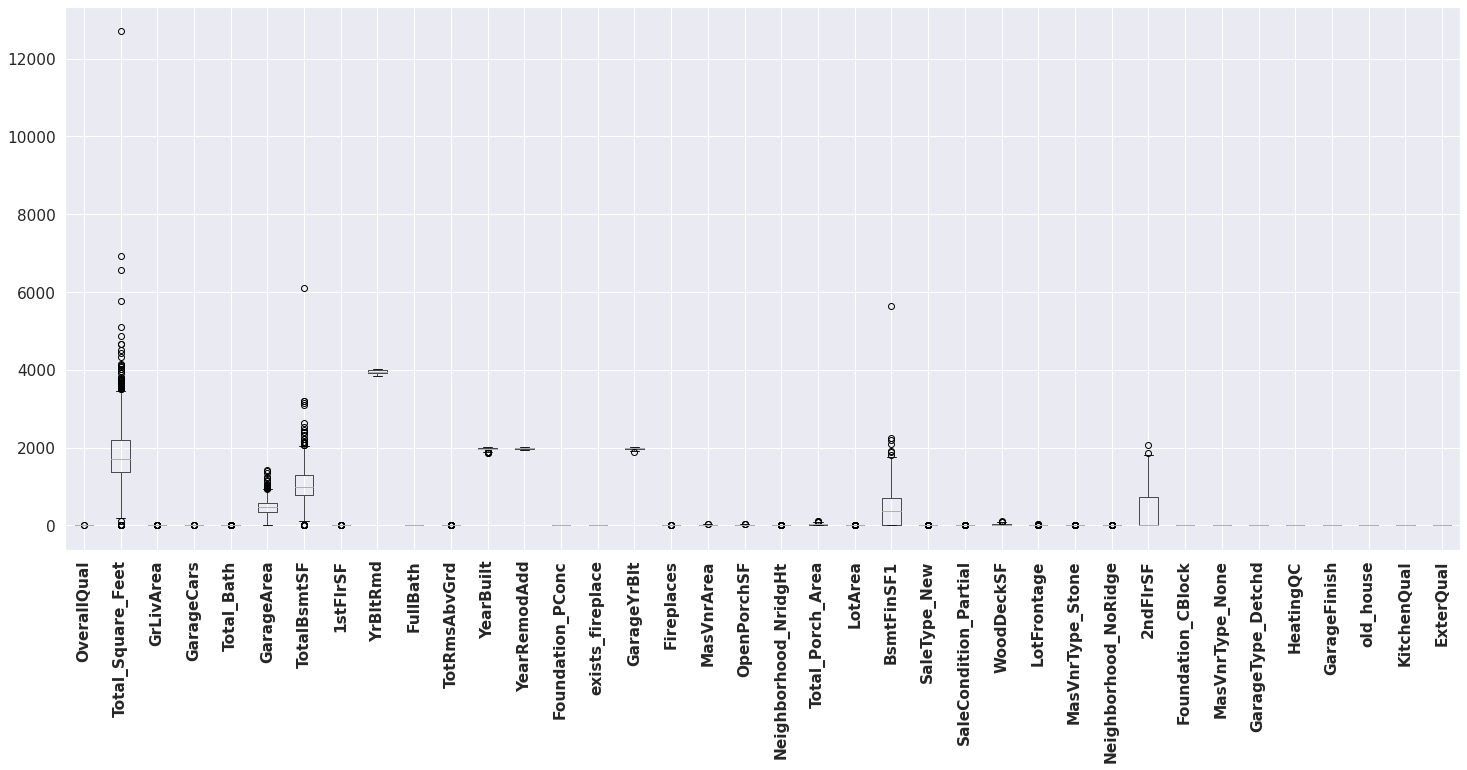

In [89]:
plt.figure(figsize =(25,10))
sns.set(font_scale = 1.4)
train.boxplot(column = best_columns)
plt.xticks(weight = 'bold', rotation =90)

In [90]:
train['SalePrice_Log1p']= np.log1p(train.SalePrice)

In [91]:
train.head()

Id  MSSubClass  LotFrontage    LotArea    Street  Alley  LotShape  \
0   1           5    13.668864  13.424520  1.965139      1         3   
1   2           0    15.311587  13.694527  1.965139      1         3   
2   3           5    14.011693  14.034133  1.965139      1         0   
3   4           6    13.079140  13.683421  1.965139      1         0   
4   5           5    15.722536  14.550142  1.965139      1         0   

   LandSlope  OverallQual  OverallCond  YearBuilt  YearRemodAdd  MasVnrArea  \
0        0.0            7            4       2003          2003   19.509966   
1        0.0            6            7       1976          1976    0.000000   
2        0.0            7            4       2001          2002   17.835996   
3        0.0            7            4       1915          1970    0.000000   
4        0.0            8            4       2000          2000   25.518156   

   ExterQual  ExterCond   BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  \
0   5.498765   5.100237  54.556642  5.218987      6.112249             2   
1  11.456357   5.100237  54.556642  5.218987      1.372290             0   
2   5.498765   5.100237  54.556642  5.218987      3.429155             2   
3  11.456357   5.100237  54.556642  1.280547      6.112249             0   
4   5.498765   5.100237  54.556642  5.218987      0.000000             2   

   BsmtFinSF1  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  HeatingQC  \
0       706.0   1444.255548         0.0      150.0        856.0          0   
1       978.0   1444.255548         0.0      284.0       1262.0          0   
2       486.0   1444.255548         0.0      434.0        920.0          0   
3       216.0   1444.255548         0.0      540.0        756.0          2   
4       655.0   1444.255548         0.0      490.0       1145.0          0   

   CentralAir  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  \
0   72.932968  5.318379       854           0.0   7.234115           1.0   
1   72.932968  5.550627         0           0.0   6.947212           0.0   
2   72.932968  5.362015       866           0.0   7.275132           1.0   
3   72.932968  5.388291       756           0.0   7.237969           1.0   
4   72.932968  5.493032      1053           0.0   7.470741           1.0   

   BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  KitchenQual  \
0           0.0         2         1             3       0.75096     5.077704   
1           1.0         2         0             3       0.75096    10.302990   
2           0.0         2         1             3       0.75096     5.077704   
3           0.0         1         0             3       0.75096     5.077704   
4           0.0         2         1             4       0.75096     5.077704   

   TotRmsAbvGrd  Functional  Fireplaces  FireplaceQu  GarageYrBlt  \
0             8   30.831053           0            3       2003.0   
1             6   30.831053           1            5       1976.0   
2             6   30.831053           1            5       2001.0   
3             7   30.831053           1            2       1998.0   
4             9   30.831053           1            5       2000.0   

   GarageFinish  GarageCars  GarageArea  GarageQual  GarageCond  PavedDrive  \
0             1         2.0       548.0   23.440981  2952.40927   10.465804   
1             1         2.0       460.0   23.440981  2952.40927   10.465804   
2             1         2.0       608.0   23.440981  2952.40927   10.465804   
3             2         3.0       642.0   23.440981  2952.40927   10.465804   
4             1         3.0       836.0   23.440981  2952.40927   10.465804   

   WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  \
0    0.000000    12.009558       0.000000        0.0          0.0       0.0   
1   56.339208     0.000000       0.000000        0.0          0.0       0.0   
2    0.000000     9.849185       0.000000        0.0          0.0       0.0   
3    0.000000     8.92174

In [92]:
print(min(train['SalePrice_Log1p']))
print(max(train['SalePrice_Log1p']))

10.460270761075149
13.534474352733596


Skew Dist: 1.8828757597682129
Kurtosis Dist; 6.536281860064529


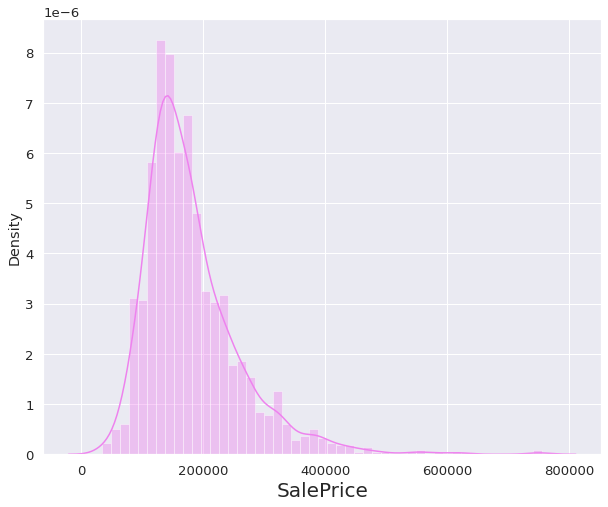

In [94]:
plt.figure(figsize=(10,8))
sns.set(font_scale= 1.2)
sns.distplot(train['SalePrice'], color = 'violet')
plt.xlabel('SalePrice', fontsize= 20)
print('Skew Dist:', train['SalePrice'].skew())
print('Kurtosis Dist;',train['SalePrice'].kurt())

Skew Dist: 1.8828757597682129
Kurtosis Dist; 6.536281860064529


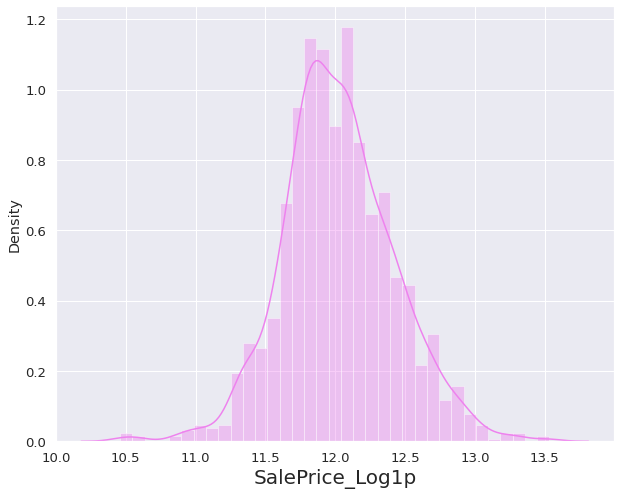

In [95]:
plt.figure(figsize=(10,8))
sns.set(font_scale= 1.2)
sns.distplot(train['SalePrice_Log1p'], color = 'violet')
plt.xlabel('SalePrice_Log1p', fontsize= 20)
print('Skew Dist:', train['SalePrice'].skew())
print('Kurtosis Dist;',train['SalePrice'].kurt())

## PCA

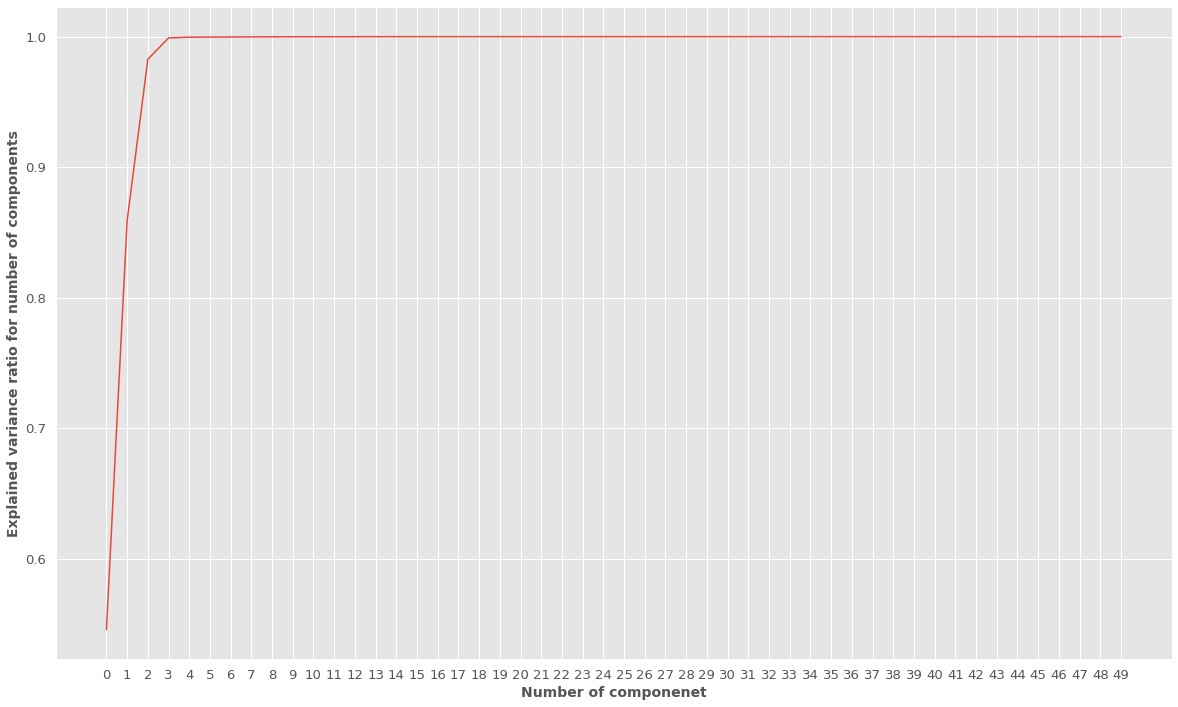

In [99]:
plt.style.use('ggplot')
plt.figure(figsize = (20,12))
rbst_scaler= RobustScaler()
train_rbst =rbst_scaler.fit_transform(train)

pca = PCA(50).fit(train_rbst)
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xticks(np.arange(0,50,1))
plt.xlabel('Number of componenet', fontweight = 'bold', size= 14)
plt.ylabel('Explained variance ratio for number of components', fontweight ='bold', size=14)

train_pca =PCA(3).fit_transform(train_rbst)

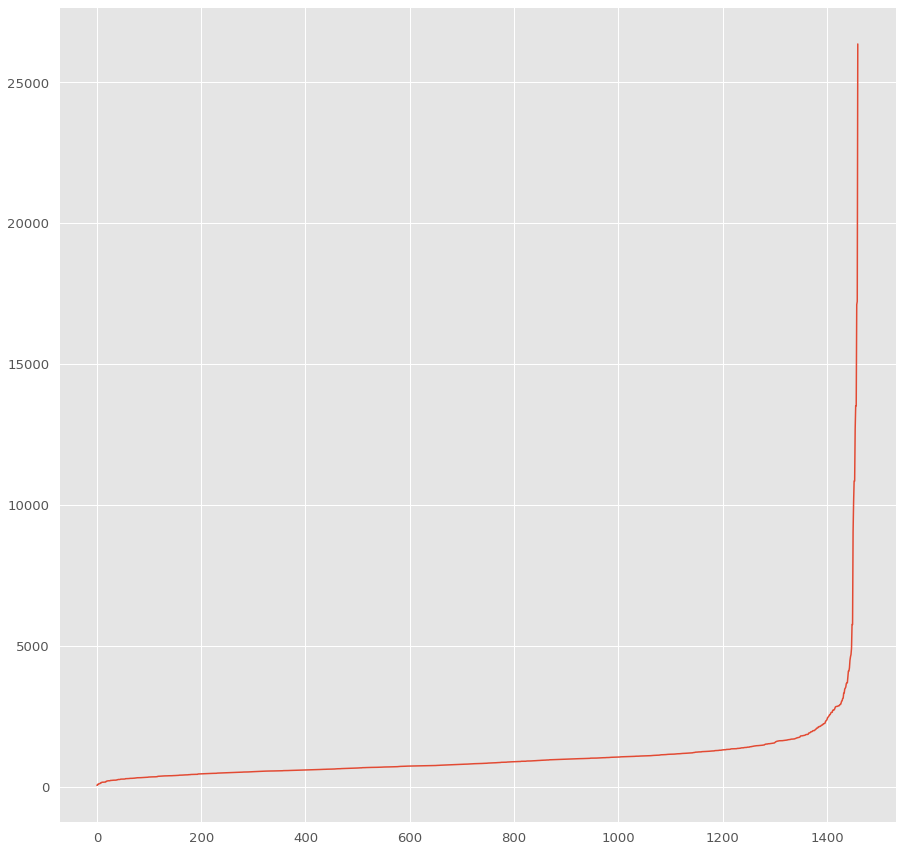

In [113]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(train)
distances, indices = nbrs.kneighbors(train)
distances = np.sort(distances, axis= 0)
distances = distances[:,1]
plt.figure(figsize= (15,15))
plt.plot(distances)


In [116]:
dbscan  =  DBSCAN(eps = 1400, min_samples = 20).fit(train_pca)
core_samples_mask =np.zeros_like(dbscan.labels_, dtype= bool)
core_samples_mask[dbscan.core_sample_indices_] = True
labels = dbscan.labels_
n_clusters_ = len(set(labels))- (1 if -1 in labels else 0)

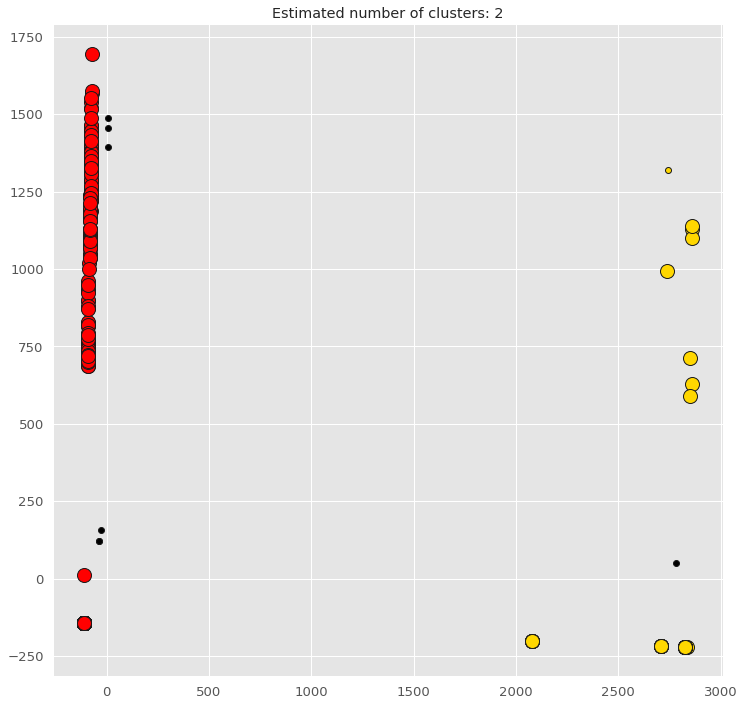

In [126]:
unique_labels = set(labels)
plt.figure(figsize = (12,12))
colors = [plt.cm.prism(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
  if k == -1:
    col = [0,0,0,1]
  class_member_mask = (labels == k )

  xy = train_pca[class_member_mask & core_samples_mask]
  plt.plot(xy[:,0], xy[:,1], 'o', markerfacecolor = tuple(col), markeredgecolor = 'k',markersize =14)

  xy = train_pca[class_member_mask & ~core_samples_mask]
  plt.plot(xy[:,0], xy[:,1], 'o', markerfacecolor = tuple(col), markeredgecolor = 'k',markersize =6)

plt.title('Estimated number of clusters: %d'% n_clusters_)
plt.show()


In [127]:
labels = pd.DataFrame(labels, columns = ['Classes'])
print(labels[labels['Classes']==-1])

      Classes
197        -1
810        -1
1170       -1
1182       -1
1298       -1
1386       -1
1423       -1


In [128]:
train = pd.concat([train, labels], axis=1)

In [129]:
train[train.Classes==-1]

Id  MSSubClass  LotFrontage    LotArea    Street  Alley  LotShape  \
197    198           7    23.181520  15.851261  1.965139      1         3   
810    811           0    15.102191  13.811203  1.965139      1         3   
1170  1171           8    14.890046  13.755756  1.965139      1         3   
1182  1183           5    22.181021  14.751522  1.965139      1         0   
1298  1299           5    31.456867  18.058230  1.965139      1         2   
1386  1387           5    15.311587  14.898479  1.965139      1         0   
1423  1424           8    14.457070  15.268761  1.965139      1         0   

      LandSlope  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
197         0.0            8            3       1918          1990   
810         0.0            6            5       1974          1999   
1170        0.0            6            5       1977          1977   
1182        0.0           10            4       1996          1996   
1298        0.0           10            4       2008          2008   
1386        0.0            7            4       1978          1978   
1423        0.0            6            6       1966          1966   

      MasVnrArea  ExterQual  ExterCond   BsmtQual  BsmtCond  BsmtExposure  \
197     0.000000   5.498765   2.335064  54.556642  5.218987      6.112249   
810    14.086205  11.456357   5.100237  54.556642  5.218987      6.112249   
1170    0.000000  11.456357   5.100237  54.556642  5.218987      0.000000   
1182    0.000000   5.498765   5.100237  54.556642  5.218987      0.000000   
1298   36.986264   0.000000   5.100237  54.556642  5.218987      1.372290   
1386   18.939832  11.456357   5.100237  17.781582  5.218987      6.112249   
1423    0.000000   5.498765   2.335064  54.556642  5.218987      0.000000   

      BsmtFinType1  BsmtFinSF1  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  \
197              2      1036.0    193.630044       184.0      140.0   
810              0       663.0    193.630044       377.0        0.0   
1170             0       522.0   1444.255548         0.0      574.0   
1182             2      2096.0   1444.255548         0.0      300.0   
1298             2      5644.0   1444.255548         0.0      466.0   
1386             1       790.0    193.630044       469.0      133.0   
1423             5         0.0   1444.255548         0.0      697.0   

      TotalBsmtSF  HeatingQC  CentralAir  1stFlrSF  2ndFlrSF  LowQualFinSF  \
197        1360.0          2   72.932968  5.594622      1360      4.792411   
810        1040.0          1   72.932968  5.572167         0      0.000000   
1170       1096.0          4   72.932968  5.478843         0      0.000000   
1182       2396.0          0   72.932968  5.923585      2065      0.000000   
1298       6110.0          0   72.932968  6.289154       950      0.000000   
1386       1392.0          4   72.932968  5.608254      1392      0.000000   
1423        697.0          4   72.932968  5.680267       626      0.000000   

      GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
197    7.797758           1.0           1.0         2         0             4   
810    6.981777           1.0           0.0         1         1             3   
1170   6.832622           1.0           0.0         1         0             3   
1182   8.138683           1.0           0.0         3         1             4   
1298   8.355351           2.0           0.0         2         1             3   
1386   7.693103           1.0           0.0         3         1             5   
1423   7.472025           0.0           0.0         2         0             4   

      KitchenAbvGr  KitchenQual  TotRmsAbvGrd  Functional  Fireplaces  \
197        0.75096     5.077704             8   30.831053           1   
810        0.75096     5.077704             5   30.831053           1   
1170       0.75096    10.302990             6   30.831053           1   
1182       0.75096     0.000000            10   30.831053           2   
1298 

In [130]:
train.drop(labels[labels['Classes']==-1].index, axis=0, inplace= True)

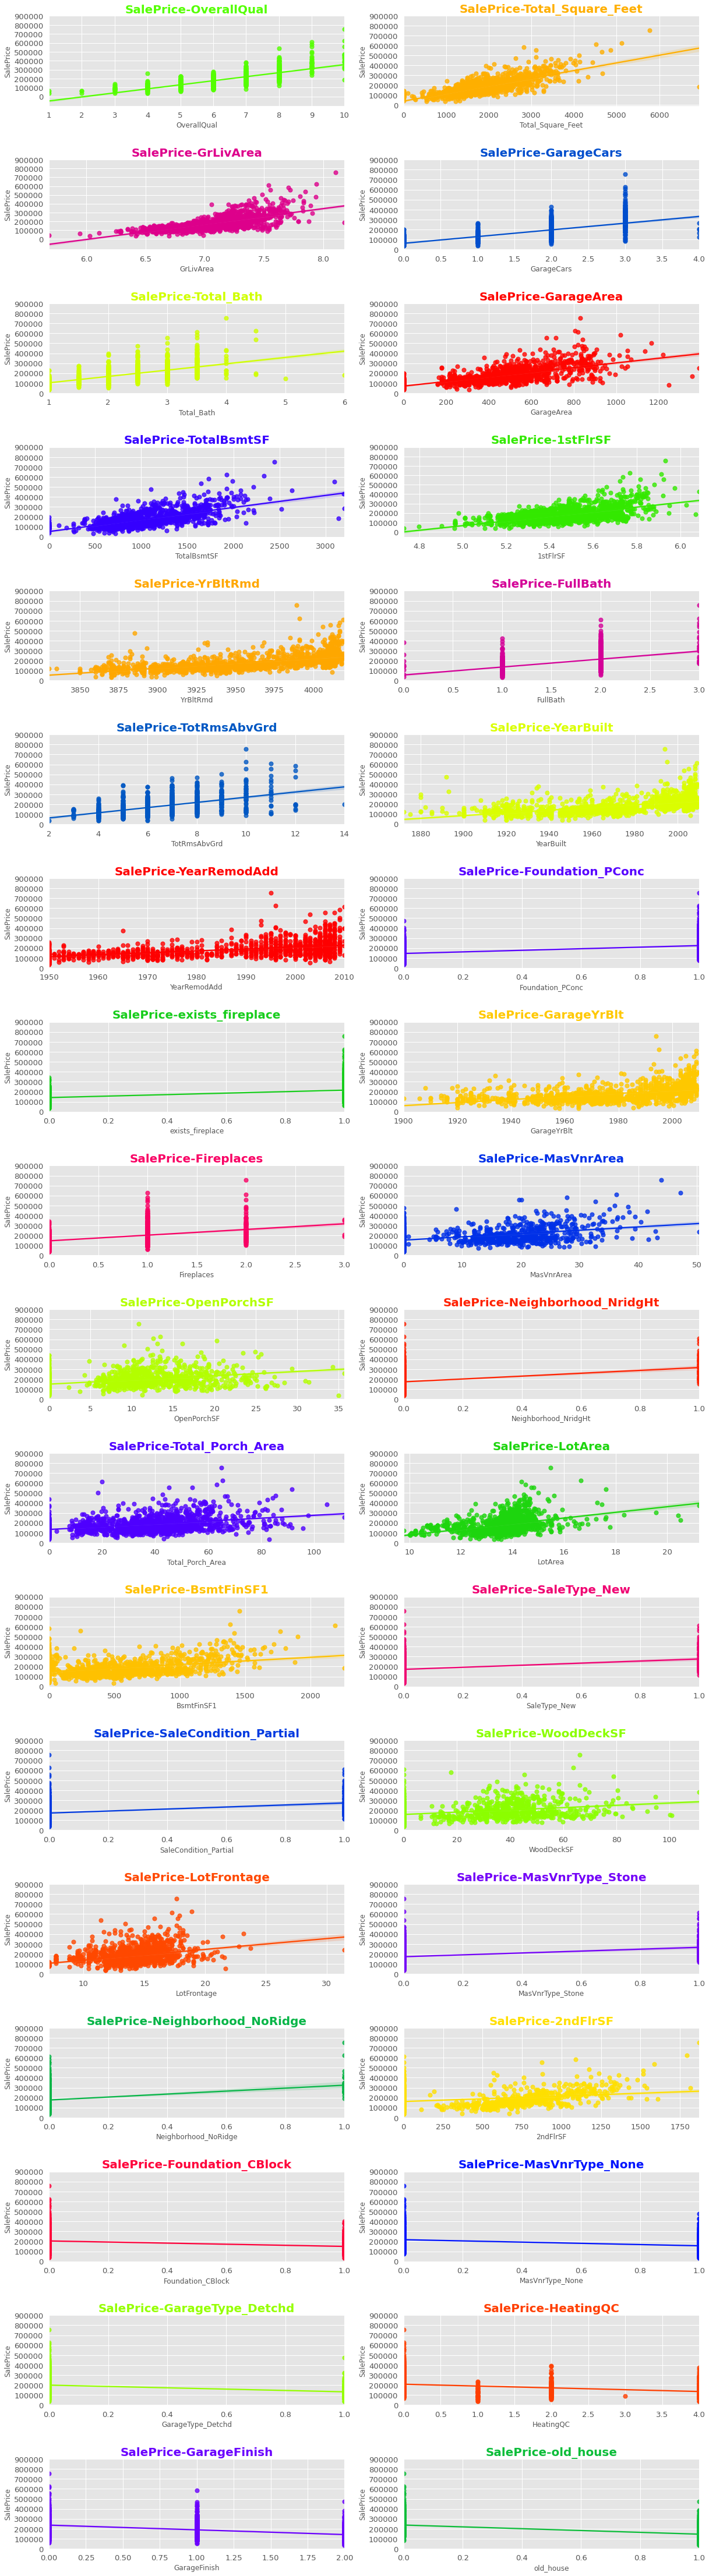

In [133]:
fig, axes = plt.subplots(18,2, figsize =(20,80))
fig.subplots_adjust(hspace= 0.6)
colors = [plt.cm.prism_r(each) for each in np.linspace(0,1, len(best_columns))]
for i, ax, color in zip(best_columns, axes.flatten(), colors):
  sns.regplot(x= train[i], y= train['SalePrice'], fit_reg =True, marker= 'o', scatter_kws = {'s':50,'alpha':0.8}, 
              color = color, ax=ax)
  plt.xlabel(i, fontsize=12)
  plt.ylabel('SalePrice', fontsize=12)
  ax.set_yticks(np.arange(0, 900001, 100000))
  ax.set_title('SalePrice'+'-'+str(i),color = color, fontweight='bold', size=20)

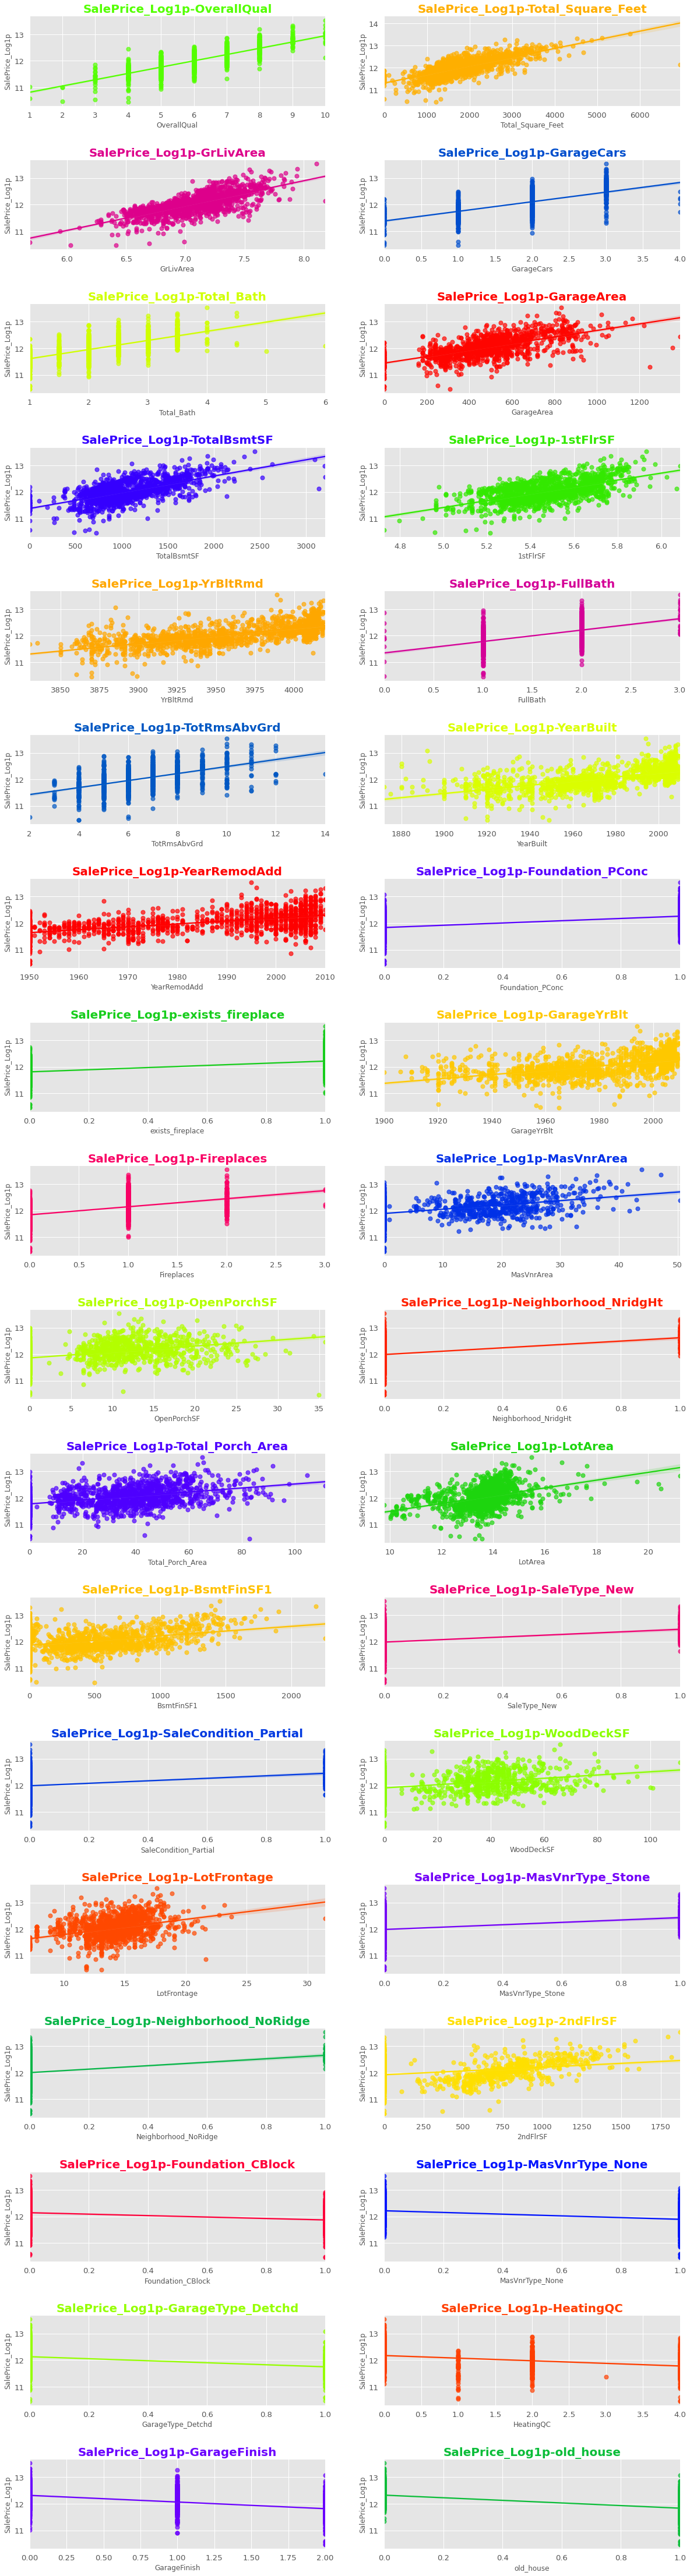

In [135]:
fig, axes = plt.subplots(18,2, figsize =(20,80))
fig.subplots_adjust(hspace= 0.6)
colors = [plt.cm.prism_r(each) for each in np.linspace(0,1, len(best_columns))]
for i, ax, color in zip(best_columns, axes.flatten(), colors):
  sns.regplot(x= train[i], y= train['SalePrice_Log1p'], fit_reg =True, marker= 'o', scatter_kws = {'s':50,'alpha':0.7}, 
              color = color, ax=ax)
  plt.xlabel(i, fontsize=12)
  plt.ylabel('SalePrice_Log1p', fontsize=12)
  ax.set_title('SalePrice_Log1p'+'-'+str(i),color = color, fontweight='bold', size=20)

In [137]:
train= train[train.GarageArea *train.GarageCars <3700]
train = train[(train.FullBath+(train.HalfBath*0.5)+train.BsmtFullBath+(train.BsmtHalfBath*0.5))<5]

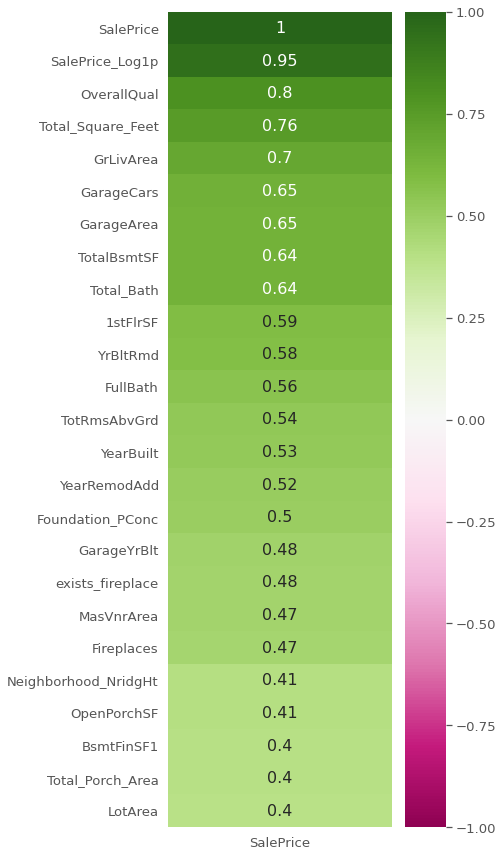

In [138]:
corr1_new_train=train.corr()
plt.figure(figsize=(5,15))
sns.heatmap(corr1_new_train[['SalePrice']].sort_values(by=['SalePrice'],ascending=False).head(25),annot_kws={"size": 16},vmin=-1, cmap='PiYG', annot=True)
sns.set(font_scale=2)


In [140]:
train.isna().sum().sum()

0

In [141]:
test.isna().sum().sum()

1459

In [142]:
del test['SalePrice']

In [143]:
train.head()

Id  MSSubClass  LotFrontage    LotArea    Street  Alley  LotShape  \
0   1           5    13.668864  13.424520  1.965139      1         3   
1   2           0    15.311587  13.694527  1.965139      1         3   
2   3           5    14.011693  14.034133  1.965139      1         0   
3   4           6    13.079140  13.683421  1.965139      1         0   
4   5           5    15.722536  14.550142  1.965139      1         0   

   LandSlope  OverallQual  OverallCond  YearBuilt  YearRemodAdd  MasVnrArea  \
0        0.0            7            4       2003          2003   19.509966   
1        0.0            6            7       1976          1976    0.000000   
2        0.0            7            4       2001          2002   17.835996   
3        0.0            7            4       1915          1970    0.000000   
4        0.0            8            4       2000          2000   25.518156   

   ExterQual  ExterCond   BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  \
0   5.498765   5.100237  54.556642  5.218987      6.112249             2   
1  11.456357   5.100237  54.556642  5.218987      1.372290             0   
2   5.498765   5.100237  54.556642  5.218987      3.429155             2   
3  11.456357   5.100237  54.556642  1.280547      6.112249             0   
4   5.498765   5.100237  54.556642  5.218987      0.000000             2   

   BsmtFinSF1  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  HeatingQC  \
0       706.0   1444.255548         0.0      150.0        856.0          0   
1       978.0   1444.255548         0.0      284.0       1262.0          0   
2       486.0   1444.255548         0.0      434.0        920.0          0   
3       216.0   1444.255548         0.0      540.0        756.0          2   
4       655.0   1444.255548         0.0      490.0       1145.0          0   

   CentralAir  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  \
0   72.932968  5.318379       854           0.0   7.234115           1.0   
1   72.932968  5.550627         0           0.0   6.947212           0.0   
2   72.932968  5.362015       866           0.0   7.275132           1.0   
3   72.932968  5.388291       756           0.0   7.237969           1.0   
4   72.932968  5.493032      1053           0.0   7.470741           1.0   

   BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  KitchenQual  \
0           0.0         2         1             3       0.75096     5.077704   
1           1.0         2         0             3       0.75096    10.302990   
2           0.0         2         1             3       0.75096     5.077704   
3           0.0         1         0             3       0.75096     5.077704   
4           0.0         2         1             4       0.75096     5.077704   

   TotRmsAbvGrd  Functional  Fireplaces  FireplaceQu  GarageYrBlt  \
0             8   30.831053           0            3       2003.0   
1             6   30.831053           1            5       1976.0   
2             6   30.831053           1            5       2001.0   
3             7   30.831053           1            2       1998.0   
4             9   30.831053           1            5       2000.0   

   GarageFinish  GarageCars  GarageArea  GarageQual  GarageCond  PavedDrive  \
0             1         2.0       548.0   23.440981  2952.40927   10.465804   
1             1         2.0       460.0   23.440981  2952.40927   10.465804   
2             1         2.0       608.0   23.440981  2952.40927   10.465804   
3             2         3.0       642.0   23.440981  2952.40927   10.465804   
4             1         3.0       836.0   23.440981  2952.40927   10.465804   

   WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  \
0    0.000000    12.009558       0.000000        0.0          0.0       0.0   
1   56.339208     0.000000       0.000000        0.0          0.0       0.0   
2    0.000000     9.849185       0.000000        0.0          0.0       0.0   
3    0.000000     8.92174

## Create Model

In [144]:
X = train.drop(['SalePrice','SalePrice_Log1p',"Classes"], axis=1)
y = train.SalePrice_Log1p

In [161]:
def overfit_reducer(df):
  overfit =[]

  for i in df.columns:
    counts= df[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(df) * 100 >99.9:
      overfit.append(i)
  overfit = list(overfit)
  return overfit

overfitted_features = overfit_reducer(X)

In [162]:
print(X.shape)
print(test.shape)

(1447, 231)
(1459, 231)


In [163]:
X.drop(overfitted_features, axis=1, inplace= True)
test.drop(overfitted_features, axis=1, inplace= True)
print('X.shape', X.shape)
print('test.shape', test.shape)

X.shape (1447, 211)
test.shape (1459, 211)


In [164]:
std_scaler = StandardScaler()
rbst_scaler = RobustScaler()
power_transformer =PowerTransformer()
X_std = std_scaler.fit_transform(X)
X_rbst = rbst_scaler.fit_transform(X)
X_pwr = power_transformer.fit_transform(X)

test_std = std_scaler.transform(test)
test_rbst = rbst_scaler.transform(test)
test_pwr = power_transformer.transform(test)


In [166]:
X_train,X_test, y_train, y_test =train_test_split(X_std, y, test_size =0.002, random_state = 52)
print("X_train Shape", X_train.shape)
print("X_test Shape", X_test.shape)
print("y_train Shape", y_train.shape)
print("y_test Shape", y_test.shape)


X_train Shape (1444, 211)
X_test Shape (3, 211)
y_train Shape (1444,)
y_test Shape (3,)


In [168]:
lgb_regressor = lgbm.LGBMRegressor(objective = 'regression', num_leaves = 5, learning_rate = 0.035, n_estimators = 2177,
                                  max_bin =50, bagging_fraction= 0.65, bagging_freq = 5, bagging_seed =7, feature_fraction =0.201,
                                  feature_fraction_seed =7, n_jobs=-1)
lgb_regressor.fit(X_train,y_train)
y_head = lgb_regressor.predict(X_test)
print("-"*10 + "LGBM"+"-"*10)
print("R square Accuracy", r2_score(y_test, y_head))
print("Mean absolute Error Accuracy:", mean_absolute_error(y_test, y_head))
print("Mean squared Error Accuracy:", mean_squared_error(y_test, y_head))


----------LGBM----------
R square Accuracy -0.680425513350065
Mean absolute Error Accuracy: 0.1895085761131797
Mean squared Error Accuracy: 0.047241864309051314


In [169]:
gb_reg = GradientBoostingRegressor(n_estimators=1992, learning_rate=0.03005, max_depth=4, max_features='sqrt',
                                   min_samples_leaf= 15, min_samples_split =14, loss='huber', random_state=42)
gb_reg.fit(X_train,y_train)
y_head = gb_reg.predict(X_test)
print("-"*10 + "GBR"+"-"*10)
print("R square Accuracy", r2_score(y_test, y_head))
print("Mean absolute Error Accuracy:", mean_absolute_error(y_test, y_head))
print("Mean squared Error Accuracy:", mean_squared_error(y_test, y_head))


----------GBR----------
R square Accuracy -0.8478891330733493
Mean absolute Error Accuracy: 0.18239174517426449
Mean squared Error Accuracy: 0.05194977521424709


In [171]:
kfolds = KFold(n_splits= 10, shuffle= True, random_state=42)

alphas =[1e-9,1e-8,1e-7, 1e-6]
ridgecv_reg = make_pipeline(RidgeCV(alphas = alphas, cv= kfolds))
ridgecv_reg.fit(X_train,y_train)
y_head = ridgecv_reg.predict(X_test)
print("-"*10 + "RidgeCV"+"-"*10)
print("R square Accuracy", r2_score(y_test, y_head))
print("Mean absolute Error Accuracy:", mean_absolute_error(y_test, y_head))
print("Mean squared Error Accuracy:", mean_squared_error(y_test, y_head))


----------RidgeCV----------
R square Accuracy -0.45922189843760775
Mean absolute Error Accuracy: 0.16444471467681568
Mean squared Error Accuracy: 0.04102315894106814


In [174]:
kfolds = KFold(n_splits= 8, shuffle= True, random_state=42)

alphas =[1e-9,1e-8,1e-7, 1e-6]
lassocv_reg = make_pipeline(LassoCV(alphas = alphas, cv= kfolds))
lassocv_reg.fit(X_train,y_train)
y_head = lassocv_reg.predict(X_test)
print("-"*10 + "LassoCV"+"-"*10)
print("R square Accuracy", r2_score(y_test, y_head))
print("Mean absolute Error Accuracy:", mean_absolute_error(y_test, y_head))
print("Mean squared Error Accuracy:", mean_squared_error(y_test, y_head))


----------LassoCV----------
R square Accuracy -0.46230454276376354
Mean absolute Error Accuracy: 0.16461755756851382
Mean squared Error Accuracy: 0.041109821434473746


In [176]:
kfolds = KFold(n_splits= 8, shuffle= True, random_state=42)

alphas =[0.0001,0.0002,0.0003,0.0004,0.0005,0.0006]
l1ratio = [0.87,0.9,0.92,0.95,0.97,0.99,1]
elasticv_reg = make_pipeline(ElasticNetCV(alphas = alphas, cv= kfolds, l1_ratio = l1ratio))
elasticv_reg.fit(X_train,y_train)
y_head = elasticv_reg.predict(X_test)
print("-"*10 + "ElasticNetCV"+"-"*10)
print("R square Accuracy", r2_score(y_test, y_head))
print("Mean absolute Error Accuracy:", mean_absolute_error(y_test, y_head))
print("Mean squared Error Accuracy:", mean_squared_error(y_test, y_head))


----------ElasticNetCV----------
R square Accuracy -0.6577650288110668
Mean absolute Error Accuracy: 0.17790984099688836
Mean squared Error Accuracy: 0.04660480927313096


In [179]:
estimators = [('lgbm',lgb_regressor),
              ('gbr',gb_reg),
              ('lasso',lassocv_reg),
              ('ridge',ridgecv_reg),
              ('elasticnet', elasticv_reg)]

stack_reg = StackingRegressor(estimators=estimators, final_estimator=ExtraTreesRegressor(n_estimators= 50), n_jobs=-1)
stack_reg.fit(X_train,y_train)
y_head = stack_reg.predict(X_test)
print('-'*10+'StackingRegressor'+'-'*10)
print('R square Accuracy: ',r2_score(y_test,y_head))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_test,y_head))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_test,y_head))

----------StackingRegressor----------
R square Accuracy:  -0.028207087512025053
Mean Absolute Error Accuracy:  0.14456423031250765
Mean Squared Error Accuracy:  0.028906023696944994


In [181]:
y_head = pd.DataFrame(y_head, columns= ['Predict'])
y_test.reset_index(drop=True, inplace= True)
y_test_y_head = pd.concat([y_test,y_head], axis=1)
y_test_y_head.head()

SalePrice_Log1p    Predict
0        12.072547  12.162267
1        11.767575  12.038329
2        11.681832  11.608613

In [184]:
pred_df = pd.DataFrame()
for name, model in estimators:
  pred = model.predict(test_pwr)
  pred_df[name] = pred

In [186]:
pred_df = np.floor(np.expm1(pred_df))

In [191]:
pred_df['stack']= stack_reg.predict(test_pwr)
pred_df['stack'] = np.floor(np.expm1(pred_df['stack']))

In [192]:
pred_df.head()

lgbm       gbr     lasso     ridge  elasticnet     stack
0  123030.0  130185.0  132604.0  126888.0    124754.0  129589.0
1  161530.0  161841.0  157296.0  159595.0    159827.0  165755.0
2  184607.0  197358.0  186148.0  183916.0    182621.0  192634.0
3  204109.0  202554.0  209009.0  201642.0    201051.0  211812.0
4  181352.0  182526.0  214631.0  208759.0    207427.0  185485.0

In [193]:
final_pred = pred_df['stack']*0.1665 + pred_df['lgbm']*0.678+ pred_df['ridge']*0.1665
final_pred.head()

0    126117.7605
1    163688.1150
2    187859.1210
3    207225.9930
4    188598.2820
dtype: float64

In [194]:
sample_sub['SalePrice']= final_pred

In [195]:
sample_sub.head()

Id    SalePrice
0  1461  126117.7605
1  1462  163688.1150
2  1463  187859.1210
3  1464  207225.9930
4  1465  188598.2820

In [196]:
sample_sub.to_csv("submission.csv", index= False)